In [448]:
import pandas as pd
from openbb import obb
from datetime import date,datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import calendar
import requests
from bs4 import BeautifulSoup
import re
import mplfinance as mpf
import math


obb.user.preferences.output_type = 'dataframe'

In [350]:
url = 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates?sort=-record_date&format=json&page[number]=1&page[size]=1'

response = requests.get(url)
data = response.json()
avg_interest_treasury_rate = float(data['data'][0]['avg_interest_rate_amt']) / 100
avg_interest_treasury_rate

url_2 = 'https://fred.stlouisfed.org/series/DTB3'

fred = requests.get(url_2)

soup = BeautifulSoup(fred.text, 'html.parser')
date = soup.find_all('span', class_ = 'series-meta-value')


def interest_rate_fred_scraped():
    interest_rate_scraped = soup.find_all('span', class_ = 'series-meta-observation-value')
    interest_rate = []
    for item in another:
        number = item.text.strip()
        converted = float(number)
        if isinstance(converted, float):
            interest_rate.append(converted)
            break
        else:
            print(f'There was an error in data retrieval')
    return numbers[0]
interest_rated_yield_goverment_bonds = interest_rate_fred_scraped() / 100


def finding_recent_fred_date():
    url_2 = 'https://fred.stlouisfed.org/series/DTB3'
    
    fred = requests.get(url_2)
    
    soup = BeautifulSoup(fred.text, 'html.parser')
    date = soup.find_all('span', class_ = 'series-meta-value')
    for piece in date:
        cleaned = piece.text.strip()
        if ':' in cleaned:
            cleaned = cleaned.replace(':', ' ')
        try:
            converted = pd.to_datetime(cleaned)
            return converted
        except Exception as e:
            print(f'There was an error at {e}')


print(f'The most recent update to the FRED wesbite was on {finding_recent_fred_date()} with a rate of {interest_rated_yield_goverment_bonds}')



The most recent update to the FRED wesbite was on 2025-08-07 00:00:00 with a rate of 0.0414


In [73]:
tickers = ['AAPL']#, 'NVDA', 'googl', 'amd', 'sbux', 'ko', 'tsla', 'hood', 'v','tgt', 'pep','rblx']

todays_date = date.today()

yesterday = todays_date - timedelta(1)

five_years = todays_date - relativedelta(years = 5)

In [75]:
stats = obb.equity.ownership.share_statistics(symbol='AAPL', provider='yfinance', start_date = five_years )
fundamental = obb.equity.fundamental.income(symbol='AAPL', provider='yfinance', start_date = five_years)
fundamental

,period_ending,operating_revenue,total_revenue,cost_of_revenue,gross_profit,selling_general_and_admin_expense,research_and_development_expense,operating_expense,operating_income,other_non_operating_income_expenses,...,net_income_from_continuing_operation_net_minority_interest,normalized_ebitda,tax_rate_for_calcs,tax_effect_of_unusual_items,interest_income_non_operating,interest_expense_non_operating,net_non_operating_interest_income_expense,interest_income,interest_expense,net_interest_income
0,2024-09-30,3.910350e+11,3.910350e+11,2.103520e+11,1.806830e+11,2.609700e+10,3.137000e+10,5.746700e+10,1.232160e+11,269000000.0,...,9.373600e+10,1.346610e+11,0.241,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-30,3.832850e+11,3.832850e+11,2.141370e+11,1.691480e+11,2.493200e+10,2.991500e+10,5.484700e+10,1.143010e+11,-565000000.0,...,9.699500e+10,1.258200e+11,0.147,0.0,3.750000e+09,3.933000e+09,-183000000.0,3.750000e+09,3.933000e+09,-183000000.0
2,2022-09-30,3.943280e+11,3.943280e+11,2.235460e+11,1.707820e+11,2.509400e+10,2.625100e+10,5.134500e+10,1.194370e+11,-334000000.0,...,9.980300e+10,1.305410e+11,0.162,0.0,2.825000e+09,2.931000e+09,-106000000.0,2.825000e+09,2.931000e+09,-106000000.0
3,2021-09-30,3.658170e+11,3.658170e+11,2.129810e+11,1.528360e+11,2.197300e+10,2.191400e+10,4.388700e+10,1.089490e+11,60000000.0,...,9.468000e+10,1.231360e+11,0.133,0.0,2.843000e+09,2.645000e+09,198000000.0,2.843000e+09,2.645000e+09,198000000.0
4,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.763000e+09,2.873000e+09,890000000.0,3.763000e+09,2.873000e+09,890000000.0


In [12]:
days = 365
years = list(range(2020, 2026))
months= list(range(1,13))

def days_in_month(years, months):
    days_dict = {}
    for year in years:
        for month in months:
            days = calendar.monthrange(year, month)[1]
            days_dict[(year, month)] = days
    return days_dict

days_per_month = days_in_month(years, months)
number_of_days = sum(days_per_month.values())
number_of_days

2192

## Simple Returns

$$
\frac{p_1}{p_{t-1}} - 1 
$$

## Compound Return

$$
\log \frac{p_t}{p_{t-1}}
$$

## CAGR (Compound Annual Growth Rate) ￼

$$ 
(\frac{endingvalue}{beginning value})^\frac{1}{n} - 1
$$
###### You want the beginning value to understand the initial starting point of the investment, along with the ending value as the most recent point of the investment

###### It's always good to be able to see how much an investment grows given annual rate, ignoring volatility rate

### Sharpe Ratio

$$
\frac{R_p - R_f}{\sigma_p}
$$


#### Alpha

$$ 
\alpha = R_i - [R_f + \beta_i (R_M + R_f)]
$$


#### Delta

$$
\Delta = \frac{\partial V}{\partial S}
$$

##### More in regards to options, looks at the change in dollar

In [433]:
def closing_data(tickers):
    tickers = [ticker.upper() for ticker in tickers]
    stocks_collections = {}
    def market_performance(stock = 'SPY'):
        data = []
        dataframe = pd.DataFrame()
        # more columns
        dataframe = obb.equity.price.historical(stock,provider = 'yfinance', start_date = five_years)
        dataframe.index = pd.to_datetime(dataframe.index)
        dataframe['market_returns'] = (dataframe.loc[:,'close'] / dataframe.loc[:,'close'].shift()) - 1
        dataframe['compound_returns'] = np.log((dataframe.loc[:, 'close'] / dataframe.loc[:,'close'].shift()))  
        dataframe['CAGR_Percent'] = (dataframe.iloc[-1]['close'] / dataframe.iloc[0]['close']) ** (1/5) - 1
        dataframe['annualized_volatility'] = ((dataframe.loc[:,'close'] / dataframe.loc[:,'close'].shift())-1).std() * np.sqrt(252)
        return dataframe.dropna()
    spy = market_performance()
    window = 252
    data = []
    dataframe = pd.DataFrame()
    for ticker in tickers:
        # more columns
        dataframe = obb.equity.price.historical(ticker,provider = 'yfinance', start_date = five_years)
        dataframe.index = pd.to_datetime(dataframe.index)
        outsource = obb.equity.ownership.share_statistics(symbol=ticker, provider='yfinance', start_date = five_years)
        fundamental = obb.equity.fundamental.income(symbol= ticker, provider='yfinance', start_date = five_years)
        dataframe['underlying_symbol'] = ticker
        # dataframe['market_cap'] = dataframe['close'] * outsource['outstanding_shares']
        # dataframe['simple_returns_initial'] = (dataframe.loc[:,'close'] / dataframe.loc[:,'close'].shift()) - 1
        dataframe['simple_returns'] = dataframe['close'].pct_change() * 100
        dataframe['compound_returns'] = np.log((dataframe.loc[:, 'close'] / dataframe.loc[:,'close'].shift()))  * 100
        dataframe['excess_returns'] = dataframe['simple_returns'].mean() - interest_rated_yield_goverment_bonds                
        rolling_mean_sr = dataframe['simple_returns'].rolling(window).mean()
        squared_diff = (dataframe['simple_returns'] - rolling_mean_sr) ** 2
        rolling_variance = squared_diff.rolling(window).sum() / (window - 1)
        dataframe['rolling_volatility'] = np.sqrt(rolling_variance)
        dataframe['annualized_volatility'] = ((dataframe.loc[:,'close'] / dataframe.loc[:,'close'].shift())-1).std() * np.sqrt(252)
        dataframe['sharpe_ratio'] = (dataframe['simple_returns'].mean() - interest_rated_yield_goverment_bonds) / dataframe['annualized_volatility'] * 100
        dataframe['cagr_percent'] = ((dataframe.iloc[-1]['close'] / dataframe.iloc[0]['close']) ** (1/5) - 1) * 100
        
        def calc_beta(dataframe):
            return dataframe['simple_returns'].cov(spy['market_returns']) / spy['market_returns'].var()
        def joining_two_rates(dataframe, market = spy):
            total = pd.concat([dataframe, spy], axis = 1)
            return total
        total_data = joining_two_rates(dataframe, market = spy)[['simple_returns', 'market_returns']]

        rolling_cov = total_data['simple_returns'].rolling(window).cov(total_data['market_returns'])
        rolling_var = total_data['market_returns'].rolling(window).var()
        
        dataframe['beta'] = rolling_cov / rolling_var
        
        dataframe['alpha'] = dataframe['simple_returns'] - (avg_interest_treasury_rate + dataframe['beta'] * (total_data['market_returns'] - avg_interest_treasury_rate)) 
                
        
        stocks_collections[ticker] = dataframe.dropna()
        
        
    return stocks_collections


initial_data = closing_data(tickers)
# data = closing_data(tickers)
# apple = data['AAPL']  
# # tesla = data['TSLA']

# stocks = data.keys()

In [434]:
initial_data['AAPL'].tail(10)

,open,high,low,close,volume,split_ratio,dividend,underlying_symbol,simple_returns,compound_returns,excess_returns,rolling_volatility,annualized_volatility,sharpe_ratio,cagr_percent,beta,alpha
date,,,,,,,,,,,,,,,,,
2025-07-28,214.029999,214.850006,213.059998,214.050003,37858000,0.0,0.0,AAPL,0.079483,0.079451,0.032361,1.984453,0.294606,10.984456,15.264024,118.923623,5.196569
2025-07-29,214.179993,214.809998,210.820007,211.270004,51411700,0.0,0.0,AAPL,-1.298761,-1.307269,0.032361,1.985877,0.294606,10.984456,15.264024,119.030225,4.107017
2025-07-30,211.899994,212.389999,207.720001,209.050003,45512500,0.0,0.0,AAPL,-1.050789,-1.056348,0.032361,1.986965,0.294606,10.984456,15.264024,119.337744,4.204585
2025-07-31,208.490005,209.839996,207.160004,207.570007,80698400,0.0,0.0,AAPL,-0.707963,-0.710480,0.032361,1.987462,0.294606,10.984456,15.264024,119.357716,4.845727
2025-08-01,210.869995,213.580002,201.500000,202.380005,104434500,0.0,0.0,AAPL,-2.500362,-2.532153,0.032361,1.993620,0.294606,10.984456,15.264024,119.681395,4.581179
2025-08-04,204.509995,207.880005,201.679993,203.350006,75109300,0.0,0.0,AAPL,0.479297,0.478152,0.032361,1.991791,0.294606,10.984456,15.264024,119.372182,3.771441
2025-08-05,203.399994,205.339996,202.160004,202.919998,44155100,0.0,0.0,AAPL,-0.211462,-0.211686,0.032361,1.988840,0.294606,10.984456,15.264024,119.342373,5.498890
2025-08-06,205.630005,215.380005,205.589996,213.250000,108483100,0.0,0.0,AAPL,5.090677,4.965338,0.032361,2.014165,0.294606,10.984456,15.264024,121.508755,9.358705
2025-08-07,218.880005,220.850006,216.580002,220.029999,90224800,0.0,0.0,AAPL,3.179366,3.129871,0.032361,2.000478,0.294606,10.984456,15.264024,120.456612,8.433621


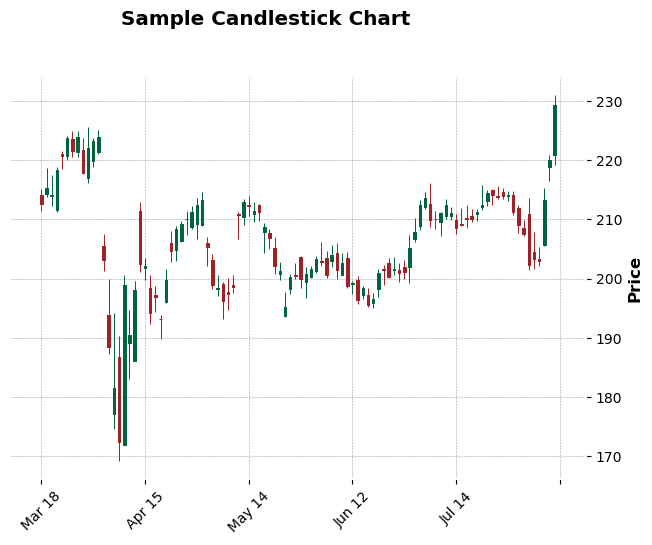

In [268]:
candles = apple[['open', 'high', 'low', 'close', 'volume']].tail(100)

candles
mpf.plot(candles, type='candle', style='charles', title='Sample Candlestick Chart', ylabel='Price')

#### More about Options formulas and their greeks

$$
\Delta_{\text{Call}} = N(d_1)
$$

##### Examines the Cumaltive Standard Deviation

$$
N(d_1)
$$
$$
d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)t}{\sigma \sqrt{t}}
$$



In [512]:
def downloading_option_data(tickers):
    tickers = [ticker.upper() for ticker in tickers]

    interest_rate = 3.831 / 100
    options_hash = {}
    
    
    for ticker in tickers:
        dataframe = obb.derivatives.options.chains(ticker, provider="yfinance", start_date = todays_date)#.set_index(['expiration','strike', 'option_type'])
        if ticker in intitial_data.keys():
            regular_stock_data =  initial_data[ticker][['close','underlying_symbol', 'annualized_volatility', 'rolling_volatility']]
            
            combined = dataframe.merge(regular_stock_data,left_on = 'underlying_symbol', right_on = 'underlying_symbol')
            combined['expiration'] = pd.to_datetime(combined['expiration'])
            to_expiration = (combined['expiration'] - datetime.now())
            days = to_expiration / np.timedelta64(1, 'D')
            years = days / 365.25
    
            d1_numerator = (
                np.log(combined['close'] / combined['strike']) +
                (interest_rate + (combined['rolling_volatility'] ** 2) / 2) * years
            )        
            d1_denominator = combined['rolling_volatility'] * np.sqrt(years)
            
                    
            combined['d_1'] = d1_numerator / d1_denominator
        
            options_hash[ticker] = combined
        else:
            print(f'Ticker {ticker} is not found in the data. Moving on.')
        
    return options_hash
    
option_data = downloading_option_data(tickers)

0          2.607792
1          2.705463
2          2.686961
3          2.772924
4          2.798289
             ...   
1450273    1.305057
1450274    1.301769
1450275    1.340081
1450276    1.338373
1450277    1.365808
Name: d_1, Length: 1450278, dtype: float64

In [513]:
option_data['AAPL']['d_1']

0          2.607792
1          2.705463
2          2.686961
3          2.772924
4          2.798289
             ...   
1450273    1.305057
1450274    1.301769
1450275    1.340081
1450276    1.338373
1450277    1.365808
Name: d_1, Length: 1450278, dtype: float64